In [104]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
from sklearn.cross_validation import LeaveOneOut, cross_val_predict
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR




from count_lagged_complaints import *
from chris_rasmus_graph_features import *

from processing import *
%matplotlib inline

In [105]:
offc = pd.read_csv('/Users/Mehraveh/Desktop/policy_lab/toy.officer_data.csv',sep=',')
cmpl = pd.read_csv('/Users/Mehraveh/Desktop/policy_lab/toy.complaint_data.csv', sep=',')

In [106]:
scale_days = 365
last_train_year = 2012
base_year = last_train_year
base_month = 12
base_day = 31
lag_max = 4
deg_thresh = 5

# cmpl_severity = add_complaint_severity(cmpl)
# r = add_complaints_by_year_and_severity(last_train_year, lag_max, cmpl_severity, offc) 
r = add_complaints_by_year(last_train_year, lag_max, cmpl, offc) 

Adding graph features

In [107]:
complaint_df = add_lag_to_complaints(cmpl, scale_days, base_year, base_month, base_day)


# build bipartite graph
G = build_bipartite_graph(complaint_df)
officer_ids = offc['officer_id'].unique()


# get feature dictionaries
num_nbr_complaints_dict = num_of_nbr_complaints(G, officer_ids, lag_max)
num_high_offenders = num_high_offender_nbrs(G, officer_ids, deg_thresh)
num_nbr_complaints_dict_pf = num_of_nbr_complaints_past_future(G, officer_ids, lag_max)


In [130]:
A=pd.DataFrame(dict([(k,pd.Series(v)) for k,v in num_nbr_complaints_dict.items()])).transpose()
A.columns = ['cmpl0','cmpl1','cmpl2','cmpl3']
B=pd.DataFrame(dict([(k,pd.Series(v)) for k,v in num_high_offenders.items()])).transpose() 
B.columns = ['num_high_offndr']
C=pd.DataFrame(dict([(k,pd.Series(v)) for k,v in num_nbr_complaints_dict_pf.items()])).transpose()
C.columns = ['cmpl0_p','cmpl1_p','cmpl2_p','cmpl3_p','cmpl0_f','cmpl1_f','cmpl2_f','cmpl3_f']


r_A = r.merge(A, left_on = 'officer_id', right_index = 1, how = 'outer')
r_AB = r_A.merge(B, left_on = 'officer_id', right_index = 1, how = 'outer')
r_AB = r_AB.fillna(0);
r_C = r_AB.merge(C, left_on = 'officer_id', right_index = 1, how = 'outer')
r_C.head()
r_C.columns

Index(['first.name', 'last.name', 'appointed.date', 'race', 'gender',
       'birth.year', 'age', 'rank', 'primary', 'secondary', 'tertiary',
       'officer_id', 'Lag0', 'Lag-1', 'Lag-2', 'Lag-3', 'cmpl0', 'cmpl1',
       'cmpl2', 'cmpl3', 'num_high_offndr', 'cmpl0_p', 'cmpl1_p', 'cmpl2_p',
       'cmpl3_p', 'cmpl0_f', 'cmpl1_f', 'cmpl2_f', 'cmpl3_f'],
      dtype='object')

Generating output vector

In [109]:
# Making Y vector
Y = add_complaints_by_year(2015, 3, cmpl, offc) 
Y=Y[[Y.columns[Y.shape[1]-1],Y.columns[Y.shape[1]-2],Y.columns[Y.shape[1]-3]]]
Y=Y.sum(axis=1)

Y.head()
Y.shape

(3884,)

Generating feature matrix

In [131]:
# Making X vector (features)
# X = offc
# X = r
# X = r_AB
X=r_C
X = X.drop(X.columns[[0,1,5,7,11]], axis=1)
X[X.columns[0]] = X[X.columns[0]].astype(str).str[0:4].astype(int)
X_cat = X[X.columns[[1,2]]]
XX=X_cat.apply(LabelEncoder().fit_transform)
X[X.columns[[1,2]]] = XX
np.where(np.isnan(X))
X_race = pd.get_dummies(X['race'])
X_race.columns = ['race0','race1','race2','race3']
X = X.drop(X.columns[[1]], axis=1)
X = X.join(X_race, how='outer')
X.head()

X=X.fillna(0);

Predictive models

0.631234552314
[[ 1.          0.63123455]
 [ 0.63123455  1.        ]]
2.24915184614


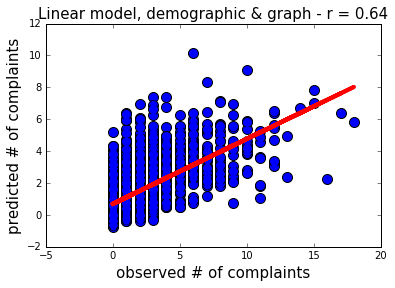

In [133]:
# LINEAR model
clf = linear_model.LinearRegression()
predicts = cross_val_predict(clf, X, Y, cv=3)

# clf.fit(X,Y)
# predicts = clf.predict(X)


fig = plt.figure()
plt.scatter(Y,predicts, s=100)
mean_squared_error(Y, predicts)
correlation = np.corrcoef(Y, predicts)[0,1]
print(correlation)


# fit with np.polyfit
m, b = np.polyfit(Y, predicts, 1)

plt.plot(Y, predicts, 'o',fillstyle='full',markeredgewidth=0)
plt.plot(Y, m*Y + b, 'r-',linewidth=4)

print(np.corrcoef(Y,predicts))
print(mean_squared_error(Y,predicts))

plt.xlabel('observed # of complaints',fontsize=15)
plt.ylabel('predicted # of complaints',fontsize=15)
plt.title('Linear model, demographic & graph - r = 0.64' ,fontsize=15)
fig.savefig('/Users/Mehraveh/Desktop/LinearModels3')


0.84926518857
[[ 1.          0.84926519]
 [ 0.84926519  1.        ]]
1.07718675437


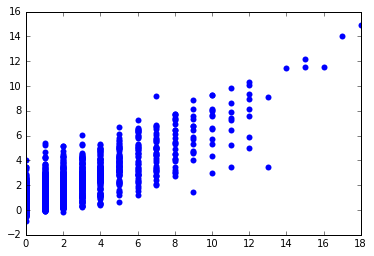

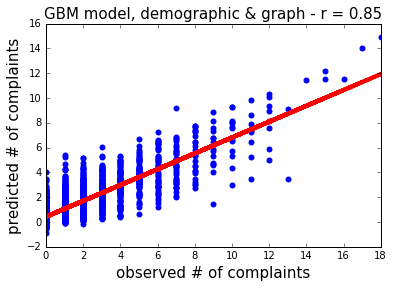

In [168]:
# GBM

clf = GradientBoostingRegressor(n_estimators=500,learning_rate=0.05,min_samples_split=5,
        min_samples_leaf=15,max_depth=5,max_features='sqrt',random_state=12,
        subsample =0.8,verbose=0,warm_start = True)

predicts = cross_val_predict(clf, X, Y, cv=3)

clf.fit(X,Y)
predicts = clf.predict(X)

mean_squared_error(Y, predicts)
plt.plot(Y,predicts,'o',fillstyle='full',markeredgewidth=0)
correlation = np.corrcoef(Y, predicts)[0,1]
print(correlation)

m, b = np.polyfit(Y, predicts, 1)
fig = plt.figure()
plt.plot(Y, predicts, 'o',fillstyle='full',markeredgewidth=0)
plt.plot(Y, m*Y + b, 'r-',linewidth=4)

print(np.corrcoef(Y,predicts))
print(mean_squared_error(Y,predicts))

plt.xlabel('observed # of complaints',fontsize=15)
plt.ylabel('predicted # of complaints',fontsize=15)
plt.title('GBM model, demographic & graph - r = 0.85' ,fontsize=15)
fig.savefig('/Users/Mehraveh/Desktop/GBMModels3')


<Container object of 27 artists>

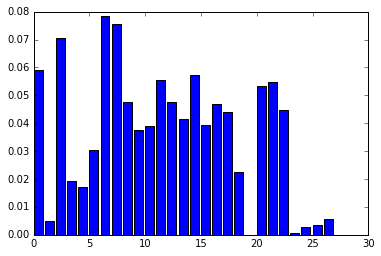

In [163]:
plt.bar(np.arange(0,np.shape(X)[1]),imp)

In [165]:
imp

array([ 0.05893348,  0.00497243,  0.07050367,  0.01919616,  0.01708257,
        0.03024968,  0.07859239,  0.07540776,  0.04771028,  0.03759645,
        0.03915198,  0.05553526,  0.04753045,  0.04163326,  0.05737559,
        0.03953217,  0.04702063,  0.04416492,  0.0225493 ,  0.        ,
        0.05331656,  0.05487519,  0.0445825 ,  0.0005813 ,  0.00287516,
        0.00337162,  0.00565923])

In [166]:
X.columns

Index(['appointed.date', 'gender', 'age', 'primary', 'secondary', 'tertiary',
       'Lag0', 'Lag-1', 'Lag-2', 'Lag-3', 'cmpl0', 'cmpl1', 'cmpl2', 'cmpl3',
       'num_high_offndr', 'cmpl0_p', 'cmpl1_p', 'cmpl2_p', 'cmpl3_p',
       'cmpl0_f', 'cmpl1_f', 'cmpl2_f', 'cmpl3_f', 'race0', 'race1', 'race2',
       'race3'],
      dtype='object')

In [62]:
# clf = RandomForestRegressor(n_estimators=500)
# predicts = cross_val_predict(clf, X, Y, cv=3)

# # clf.fit(X,Y)
# # predicts = clf.predict(X)

# mean_squared_error(Y, predicts)
# plt.plot(Y,predicts,'o')
# correlation = np.corrcoef(Y, predicts)[0,1]
# print(correlation)

# clf.fit(X,Y)
# imp = clf.feature_importances_


In [66]:
X.columns

Index(['appointed.date', 'gender', 'age', 'primary', 'secondary', 'tertiary',
       'Lag0', 'Lag-1', 'Lag-2', 'Lag-3', 'cmpl0', 'cmpl1', 'cmpl2', 'cmpl3',
       'num_high_offndr', 'cmpl0_p', 'cmpl1_p', 'cmpl2_p', 'cmpl3_p',
       'cmpl0_f', 'cmpl1_f', 'cmpl2_f', 'cmpl3_f', 'race0', 'race1', 'race2',
       'race3'],
      dtype='object')